In [1]:
dataset = "purchase100"
algorithm = "natural"

### 1. Load Dataset

In [2]:
import numpy as np 
from art.utils import to_categorical

x = []
y = []

with open("data/dataset_purchase", "r") as f:
    for datapoint in f.readlines(): 
        split = datapoint.rstrip().split(",")
        label = int(split[0]) - 1
        x.append([int(s) for s in split[1:]])
        y.append(label)

x = np.array(x).astype(np.float32)
y = to_categorical(np.array(y), 100)

target_train_size = 10000
target_test_size = 10000
x_target_train = x[:target_train_size]
y_target_train = y[:target_train_size]
x_target_test = x[target_train_size:target_train_size+target_test_size]
y_target_test = y[target_train_size:target_train_size+target_test_size]

### 2. Define Target Model

In [3]:
from torch import nn
from torchsummary import summary
import math

def purchase_model(): 
    model = nn.Sequential(            
        nn.Linear(600, 128),
        nn.ReLU(),
        nn.Linear(128, 100)
    )
    return model

summary(purchase_model(), input_size=x_target_train[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          76,928
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 100]          12,900
Total params: 89,828
Trainable params: 89,828
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


### 3. Train Target Model

In [4]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

class PytorchDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def train(dataloader, model, loss_fn, optimizer):
    for batch, (i_batch, o_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        model_outputs = model(i_batch)
        loss = loss_fn(model_outputs, o_batch)
        loss.backward()
        optimizer.step()

def get_acc(model, x, y):
    _, predictions = torch.max(model(torch.from_numpy(x)), 1)
    acc = np.mean(predictions.detach().numpy() == np.argmax(y, axis=1))
    return acc

model = purchase_model()
train_dataloader = DataLoader(PytorchDataset(x_target_train, y_target_train), batch_size=64, shuffle=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

nb_epochs = 100
best_acc = 0
for i in tqdm(range(nb_epochs)):
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)
    model.eval()
    test_acc = get_acc(model, x_target_test, y_target_test)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"models/{dataset}_{algorithm}.pth")

# purposedly trained to overfit
# model.load_state_dict(torch.load(f"models/{dataset}_{algorithm}.pth"))
model.eval()
print("Train accuracy:", get_acc(model, x_target_train, y_target_train))
print("Test accuracy:", get_acc(model, x_target_test, y_target_test))

100%|██████████| 100/100 [00:15<00:00,  6.25it/s]

Train accuracy: 1.0
Test accuracy: 0.7144


### 4. Generate Adversarial Examples using HopSkipJump

In [5]:
from art.attacks.evasion import HopSkipJump
from art.estimators.classification.pytorch import PyTorchClassifier
from numpy.random import choice

art_classifier=PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=x_target_train[0].shape,
    nb_classes=100,
)
attack = HopSkipJump(classifier=art_classifier, norm=2, targeted=False)

train_idx = choice(len(x_target_train), 100)
y_adv_train = y_target_train[train_idx]
x_adv_train = attack.generate(x=x_target_train[train_idx], y=y_adv_train)

test_idx = choice(len(x_target_test), 100)
y_adv_test = y_target_test[test_idx]
x_adv_test = attack.generate(x=x_target_test[test_idx], y=y_adv_test)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

### 5. Measure the Distribution of Distance to Decision Boundary

                0
count  100.000000
mean     1.003538
std      0.424873
min      0.450365
25%      0.700147
50%      0.885912
75%      1.230661
max      2.293344
                0
count  100.000000
mean     0.587243
std      0.572043
min      0.003505
25%      0.173180
50%      0.381079
75%      0.865299
max      2.595324


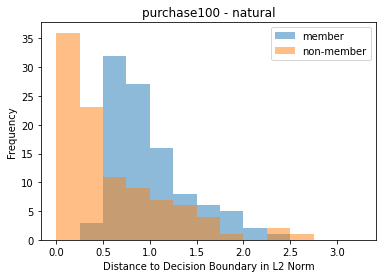

In [6]:
from matplotlib import pyplot as plt
import pandas as pd

def dist(x, x_adv):
    return np.linalg.norm(np.reshape(x_adv - x, [-1]))

dist_train = [dist(x, xa) for (x, xa) in zip(x_target_train[train_idx], x_adv_train)]
dist_test = [dist(x, xa) for (x, xa) in zip(x_target_test[test_idx], x_adv_test)]
print(pd.DataFrame(np.array(dist_train)).describe())
print(pd.DataFrame(np.array(dist_test)).describe())

bins = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25]

plt.hist(dist_train, bins, alpha=0.5, label='member')
plt.hist(dist_test, bins, alpha=0.5, label='non-member')
plt.legend(loc='upper right')
plt.title(f"{dataset} - {algorithm}")
plt.xlabel("Distance to Decision Boundary in L2 Norm")
plt.ylabel("Frequency")
plt.show()

### 6. Measure the Advantage of An Adversary in Label-Only Membership Inference Attacks

[0.   0.01 0.03 0.03 0.04 0.04 0.06 0.06 0.08 0.08 0.09 0.09 0.13 0.13
 0.14 0.14 0.15 0.15 0.18 0.18 0.21 0.21 0.22 0.22 0.23 0.23 0.24 0.24
 0.25 0.25 0.26 0.26 0.28 0.28 0.3  0.3  0.31 0.31 0.32 0.32 0.33 0.33
 0.34 0.34 0.35 0.35 0.36 0.36 0.37 0.37 0.38 0.38 0.39 0.39 0.41 0.41
 0.42 0.42 1.  ]
[0.   0.   0.   0.03 0.03 0.09 0.09 0.11 0.11 0.17 0.17 0.18 0.18 0.21
 0.21 0.3  0.3  0.33 0.33 0.37 0.37 0.38 0.38 0.46 0.46 0.48 0.48 0.52
 0.52 0.54 0.54 0.57 0.57 0.64 0.64 0.66 0.66 0.72 0.72 0.75 0.75 0.79
 0.79 0.82 0.82 0.83 0.83 0.84 0.84 0.89 0.89 0.91 0.91 0.95 0.95 0.97
 0.97 1.   1.  ]
[3.5953238e+00 2.5953238e+00 2.3667977e+00 2.1114755e+00 1.9886760e+00
 1.7045516e+00 1.6310226e+00 1.5888982e+00 1.5635543e+00 1.4627988e+00
 1.4586254e+00 1.4369433e+00 1.3725501e+00 1.3025683e+00 1.2649686e+00
 1.1531690e+00 1.1156925e+00 1.0985700e+00 1.0786438e+00 1.0406933e+00
 1.0165973e+00 1.0019702e+00 9.8227179e-01 9.4277436e-01 9.3930358e-01
 9.1787386e-01 9.1550428e-01 8.7510127e-01 

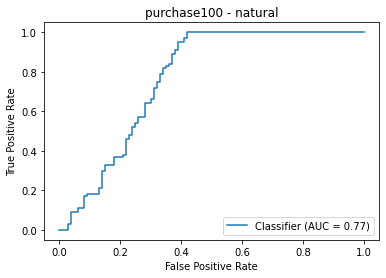

In [7]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, thresholds = roc_curve(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
print(fpr)
print(tpr)
print(thresholds)

RocCurveDisplay.from_predictions(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
plt.title(f"{dataset} - {algorithm}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### 7. Measure the Statistical Relationship between Distance to Decision Boundary and Confidence Scores

In [8]:
from scipy.stats.stats import pearsonr
import scipy

confidence_train = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_train[train_idx])]
confidence_test = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_test[test_idx])]

corr, pvalue = pearsonr(confidence_train, dist_train)
print("train correlation ", corr, pvalue)
corr, pvalue = pearsonr(confidence_test, dist_test)
print("test correlation ", corr, pvalue)

train correlation  0.41386269522221436 1.8677597432893437e-05
test correlation  0.4364855935870515 5.630110600867081e-06
